In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense,LSTM,GRU

In [2]:
df = pd.read_csv('./data.csv', index_col=0)
df.index = pd.to_datetime(df.index)
df

,NO2,CO,PM25,OZONE,PM10,NO,new_confirmed_cases,new_deaths,7_day_avg_new_cases,7_day_avg_new_deaths
Date,,,,,,,,,,
2020-01-26,0.020,0.4930,47.3,0.040,50.5,0.005,0.0,0.0,0.000000,0.000000
2020-01-27,0.042,0.8220,24.6,0.041,40.8,0.071,0.0,0.0,0.000000,0.000000
2020-01-28,0.042,0.7370,14.9,0.042,27.8,0.083,0.0,0.0,0.000000,0.000000
2020-01-29,0.031,0.7320,11.0,0.042,44.7,0.037,0.0,0.0,0.000000,0.000000
2020-01-30,0.043,1.0460,16.2,0.038,42.0,0.094,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
2020-10-14,0.040,1.0230,22.4,0.060,47.0,0.049,1223.0,19.0,1124.714286,15.571429
2020-10-15,0.057,0.7690,22.9,0.059,48.8,0.054,1201.0,22.0,1075.571429,14.714286
2020-10-16,0.041,0.7105,21.4,0.050,50.9,0.034,1041.0,22.0,1069.142857,15.285714


In [63]:
weekly_summary = pd.DataFrame()
for col in df.columns:
    if 'avg' not in col:
        if 'new' in col:
            weekly_summary[col] = df[col].resample('W').sum()
        else:
            weekly_summary[col] = df[col].resample('W').max()
weekly_summary = weekly_summary[weekly_summary['new_confirmed_cases']> 1]
weekly_summary.head()

,NO2,CO,PM25,OZONE,PM10,NO,new_confirmed_cases,new_deaths
Date,,,,,,,,
2020-03-08,0.029,0.549,22.1,0.043,44.5,0.032,13.0,0.0
2020-03-15,0.035,0.598,10.3,0.039,22.9,0.046,55.0,1.0
2020-03-22,0.034,0.491,11.1,0.039,20.5,0.051,342.0,4.0
2020-03-29,0.025,0.387,11.4,0.042,23.4,0.030,1736.0,32.0
2020-04-05,0.032,0.509,14.8,0.047,27.6,0.038,3808.0,95.0


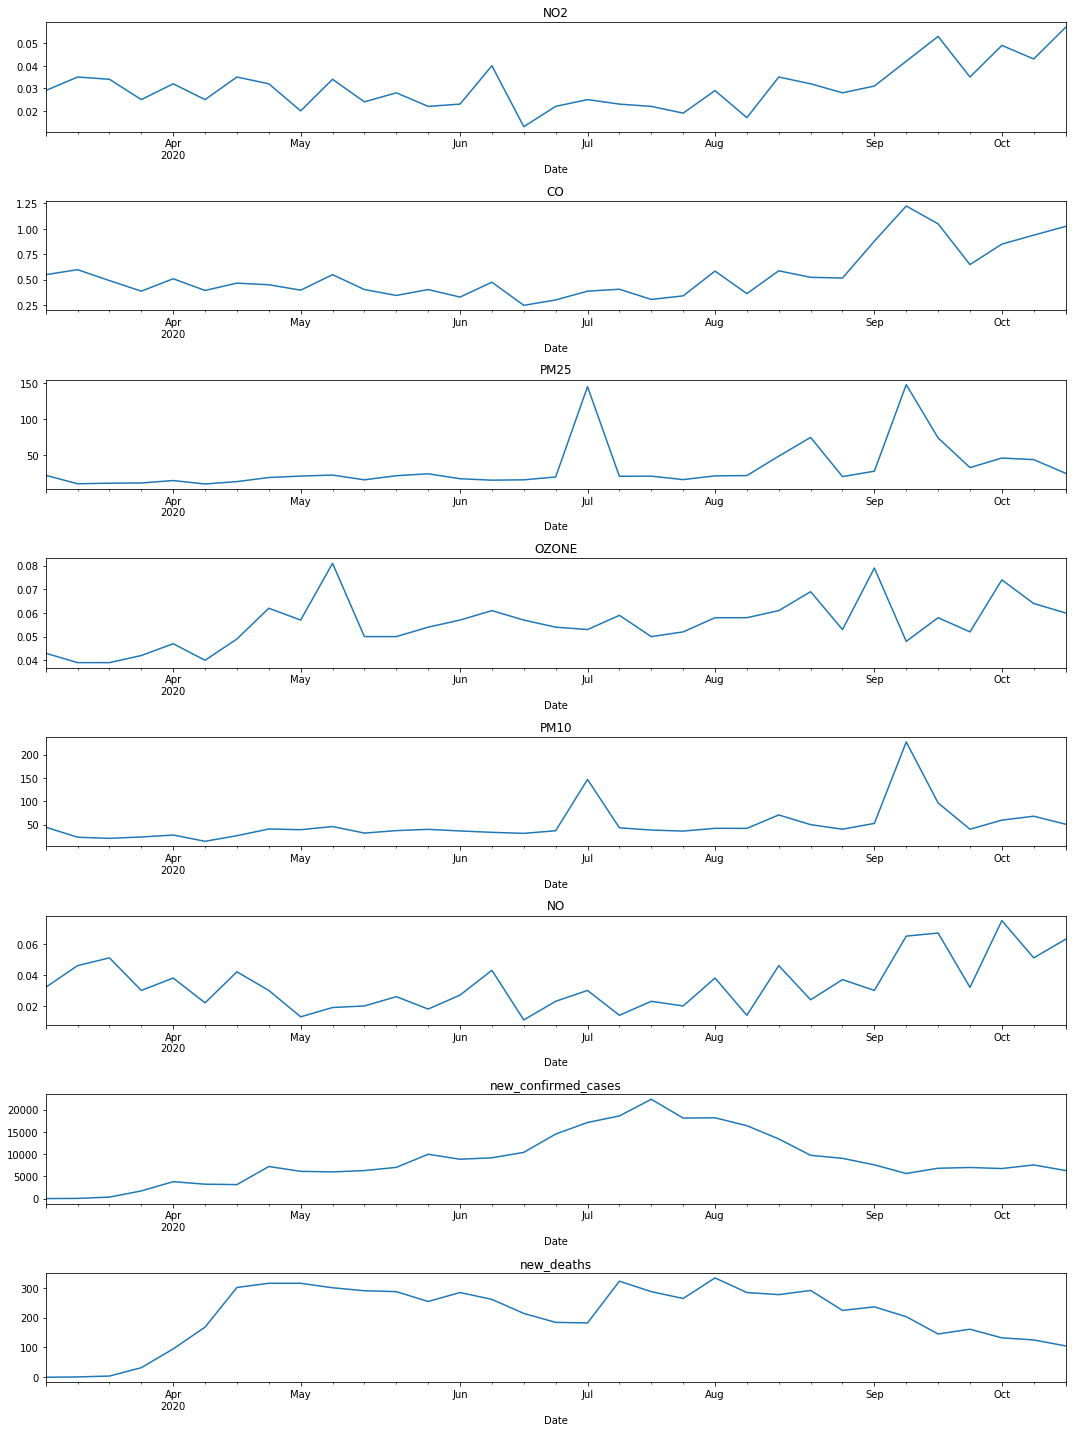

In [64]:
fig,ax = plt.subplots(8,1,figsize=(15,20))
for i,column in enumerate([col for col in weekly_summary.columns]):
    weekly_summary[column].plot(ax=ax[i])
    ax[i].set_title(column)
fig.tight_layout()

In [87]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

def training(trainX, trainY, testX, testY):
    stop_noimprovement = EarlyStopping(patience=10)
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(trainX.shape[1],trainX.shape[2]), dropout=.5))
    model.add(Dense(2))
    model.compile(loss="mse",optimizer="adam")
    history = model.fit(trainX,trainY,validation_data=(testX,testY),epochs=200,verbose=1,callbacks=[stop_noimprovement],shuffle=False)
    return history, model

def prediction(model, testX, testY):
    predicted = model.predict(testX)
    testXRe = testX.reshape(testX.shape[0],testX.shape[2])
    predicted = np.concatenate((testXRe[:,:-2], predicted),axis=1)
    predicted = scaler.inverse_transform(predicted[:,-8:])
    forecast_df = pd.DataFrame(predicted, columns=weekly_summary.columns)
    forecast_df = forecast_df[['new_confirmed_cases', 'new_deaths']]
    new_cases_rmse = np.sqrt(mean_squared_error(testY[:,-2],predicted[:,-2]))
    new_deaths_rmse = np.sqrt(mean_squared_error(testY[:,-1],predicted[:,-1]))
    return new_cases_rmse, new_deaths_rmse
    
def plots(histories):
    
    fig = plt.figure(figsize=(10,15))
    
    plt.subplot(1,1,1)
#     plt.title(f'Training for {i} input days')
    plt.plot(history.history['loss'],label='train')
    plt.plot(history.history['val_loss'],label='test')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [88]:
values = weekly_summary.values
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(-1,1))
scaled = scaler.fit_transform(values)

In [89]:
reframed = series_to_supervised(scaled,4,1)
reframed.drop(reframed.columns[[-3,-4,-5,-6,-7,-8]], axis=1, inplace=True)
values = reframed.values

In [90]:
n_train = int(len(weekly_summary)*.8)

train = values[:n_train]
test = values[n_train:]
trainX,trainY = train[:,:-2],train[:,-2:]
testX,testY = test[:,:-2],test[:,-2:]
trainX = trainX.reshape(trainX.shape[0],1,trainX.shape[1])
testX = testX.reshape(testX.shape[0],1,testX.shape[1])

In [91]:
history, model = training(trainX, trainY, testX, testY)

Train on 26 samples, validate on 3 samples
Epoch 1/200
26/26 [==============================] - 2s 93ms/sample - loss: 0.3359 - val_loss: 0.0964
Epoch 2/200
26/26 [==============================] - 0s 2ms/sample - loss: 0.3098 - val_loss: 0.0954
Epoch 3/200
26/26 [==============================] - 0s 2ms/sample - loss: 0.2773 - val_loss: 0.0944
Epoch 4/200
26/26 [==============================] - 0s 3ms/sample - loss: 0.2846 - val_loss: 0.0934
Epoch 5/200
26/26 [==============================] - 0s 4ms/sample - loss: 0.2722 - val_loss: 0.0923
Epoch 6/200
26/26 [==============================] - 0s 3ms/sample - loss: 0.2601 - val_loss: 0.0911
Epoch 7/200
26/26 [==============================] - 0s 3ms/sample - loss: 0.2580 - val_loss: 0.0901
Epoch 8/200
26/26 [==============================] - 0s 3ms/sample - loss: 0.2533 - val_loss: 0.0890
Epoch 9/200
26/26 [==============================] - 0s 2ms/sample - loss: 0.2412 - val_loss: 0.0879
Epoch 10/200
26/26 [===========================

Epoch 81/200
26/26 [==============================] - 0s 3ms/sample - loss: 0.1069 - val_loss: 0.0371
Epoch 82/200
26/26 [==============================] - 0s 3ms/sample - loss: 0.1051 - val_loss: 0.0371
Epoch 83/200
26/26 [==============================] - 0s 3ms/sample - loss: 0.0877 - val_loss: 0.0371
Epoch 84/200
26/26 [==============================] - 0s 2ms/sample - loss: 0.1029 - val_loss: 0.0371
Epoch 85/200
26/26 [==============================] - 0s 3ms/sample - loss: 0.0677 - val_loss: 0.0371
Epoch 86/200
26/26 [==============================] - 0s 3ms/sample - loss: 0.0941 - val_loss: 0.0371
Epoch 87/200
26/26 [==============================] - 0s 3ms/sample - loss: 0.0695 - val_loss: 0.0371
Epoch 88/200
26/26 [==============================] - 0s 3ms/sample - loss: 0.0881 - val_loss: 0.0371
Epoch 89/200
26/26 [==============================] - 0s 2ms/sample - loss: 0.0877 - val_loss: 0.0372
Epoch 90/200
26/26 [==============================] - 0s 2ms/sample - loss: 0.0801

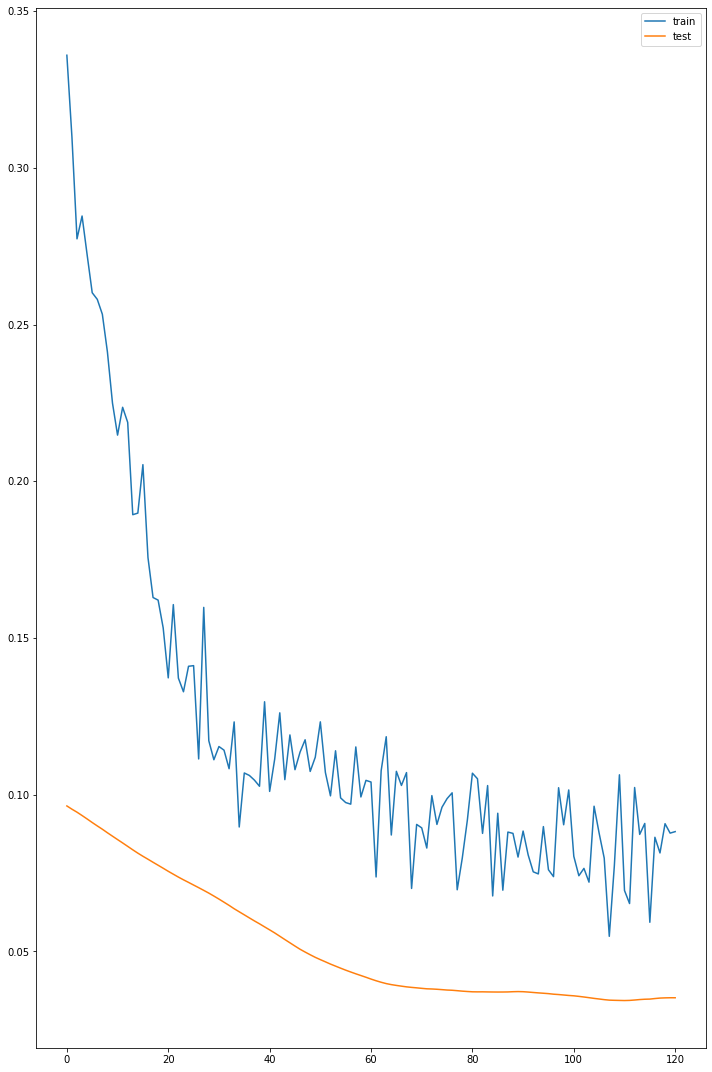

In [92]:
plots(history)

In [83]:
cases_rmse, deaths_rmse = prediction(model, testX, testY)

(3, 32)
(3, 32)


In [84]:
cases_rmse

7786.711

In [85]:
cases_rmse/(weekly_summary['new_confirmed_cases'].max() - weekly_summary['new_confirmed_cases'].min())

0.3490546412721893

In [52]:
weekly_summary

,NO2,CO,PM25,OZONE,PM10,NO,new_confirmed_cases,new_deaths
Date,,,,,,,,
2020-03-08,0.029,0.549,22.1,0.043,44.5,0.032,13.0,0.0
2020-03-15,0.035,0.598,10.3,0.039,22.9,0.046,55.0,1.0
2020-03-22,0.034,0.491,11.1,0.039,20.5,0.051,342.0,4.0
2020-03-29,0.025,0.387,11.4,0.042,23.4,0.030,1736.0,32.0
2020-04-05,0.032,0.509,14.8,0.047,27.6,0.038,3808.0,95.0
2020-04-12,0.025,0.394,10.0,0.040,14.2,0.022,3242.0,168.0
2020-04-19,0.035,0.466,13.3,0.049,26.2,0.042,3152.0,301.0
2020-04-26,0.032,0.450,19.0,0.062,40.5,0.030,7218.0,315.0
2020-05-03,0.020,0.397,21.0,0.057,39.1,0.013,6132.0,315.0


In [ ]:
n_train = int(len(df)*.8)

histories = []
predictions = []

for i in [4]:
    print(f'***** Training for {i} input days *****')
    reframed = series_to_supervised(scaled,i,1)
    reframed.drop(reframed.columns[[-3,-4,-5,-6,-7,-8]], axis=1, inplace=True)
    values = reframed.values
    train = values[:n_train]
    test = values[n_train:]
    trainX,trainY = train[:,:-2],train[:,-2:]
    testX,testY = test[:,:-2],test[:,-2:]
    trainX = trainX.reshape(trainX.shape[0],1,trainX.shape[1])
    testX = testX.reshape(testX.shape[0],1,testX.shape[1])
    
    history, model = training(trainX, trainY, testX, testY)
    histories.append((history, model))
    
    cases_rmse, deaths_rmse = prediction(model, testX, testY)
    predictions.append((cases_rmse, deaths_rmse))

In [ ]:
plots(histories)

In [ ]:
cases_rmse = [x[0] for x in predictions]
deaths_rmse = [x[1] for x in predictions]

In [ ]:
fig = plt.figure(figsize=(15,5))

for (i, rmse, title) in zip([1,2], [cases_rmse, deaths_rmse], ['7 Day New Cases Avg RMSE', '7 Day New Deaths Avg RMSE']):
    plt.subplot(1,2,i)
    plt.plot(range(1,len(predictions)+1),rmse)
    plt.plot(range(1,len(predictions)+1),rmse,'or')
    plt.title(title)
    plt.xlabel('# of input days')
    plt.ylabel('RMSE')
    
plt.tight_layout()
plt.show()

In [ ]:
cases_rmse